In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from featuremodel import extended_hinton, load_data, chooseln
from scipy.special import betaln
from scipy import stats
from matplotlib.colorbar import ColorbarBase
from featuremodel import MatrixModel
import itertools
from collections import OrderedDict

cmap = sns.blend_palette(['dodgerblue','seagreen','gold','orangered'], as_cmap=True)

colors = ["black", "azure","apple","golden yellow",   "neon pink"]
cmap = sns.blend_palette(sns.xkcd_palette(colors), as_cmap=True)

# cmap = sns.blend_palette(sns.color_palette("Set1", 5), as_cmap=True)

labels, layers, K, N = load_data(transpose=False)
layer_boundaries = np.hstack((0, np.where(np.diff(layers) > 0)[0]+1))-.5
P = K/N

def plot_connections(P, labels, vmax=None):
    sns.set_style('whitegrid')
    sns.set_context('paper',rc={"lines.linewidth": 2, 'font.size':12, 'font.family':'Helvetica'})
    fig = plt.figure(figsize=(4.6,4.6), dpi=300)
    gs = plt.GridSpec(5,20)

    ax = fig.add_subplot(gs[:,:17])
    n = len(labels)

    cnorm = extended_hinton(ax, P, P, matrix_style=True, cmap=cmap, 
                            vmax=vmax if vmax is not None else P.max(), 
                            cmin=0, cmax=1,enforce_box=True)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
#     ax.set_title(r'full connection probability matrix', fontweight='bold')
    ax.set_xlim((-1,n))
    ax.set_ylim((-1,n))
    ax.set_ylabel('postsynaptic')
    ax.set_xlabel('presynaptic')
    ax_color = fig.add_subplot(gs[1:4,18:])
    cbar = ColorbarBase(ax_color, cmap=cmap, norm=cnorm)
    fig.tight_layout()
    ax.invert_yaxis()

    return fig, {'matrix':ax, 'color':ax_color}
    
nll = OrderedDict()
nparam = OrderedDict()
models = OrderedDict()
cv = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named 'featuremodel'

# Define layer variables

In [12]:
def add_non_accounted(coupled, accounted_for=None):
    if accounted_for is None:
        accounted_for = np.zeros_like(K, dtype=bool)
    for mr in coupled:
        accounted_for |= mr

    for layer in [layer1, layer23i,layer23p, layer5i, layer5p]: 
        for other_layer in [layer1, layer23i,layer23p, layer5i, layer5p]: 
            mr = np.zeros_like(K, dtype=bool)
            mr[layer, other_layer] = True
            coupled.append(mr & ~accounted_for)
    return coupled

    

layer1 = slice(0,2)
layer23 = slice(2,10)
layer23i = slice(2,9)
layer23mc = slice(2,3)
layer23ngc = slice(3,4)
layer23other = slice(4,9)
layer23p = slice(9,10)
layer23woMC = slice(3,10)
layer23iwoMC = slice(3,9)

layer5 = slice(10,17)
layer5i = slice(10,16)
layer5mc = slice(10,11)
layer5ngc = slice(11,12)
layer5other = slice(12,16)
layer5p = slice(16,17)
layer5woMC = slice(11,17)
layer5iwoMC = slice(11,16)

# Plot for paper

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from featuremodel import extended_hinton, load_data, chooseln
from scipy.special import betaln
from scipy import stats
from matplotlib.colorbar import ColorbarBase
from featuremodel import MatrixModel
import itertools
from collections import OrderedDict
from matplotlib.colors import Normalize
#from theano import tensor as T
#import theano as th
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg
from matplotlib.pyplot import fill, cm, Rectangle
import matplotlib.pyplot as plt
from scipy.special import gammaln, betaln
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from sklearn.cluster import KMeans
import warnings
from sklearn import cross_validation
import pandas as pd
from itertools import product
from scipy import stats

INI = np.loadtxt('INI.txt');
labels, layers, K, N = load_data(transpose=False)


cmap = sns.blend_palette(['dodgerblue','seagreen','gold','orangered'], as_cmap=True)

colors = ["black", "azure","apple","golden yellow",   "neon pink"]
cmap = sns.blend_palette(sns.xkcd_palette(colors), as_cmap=True)
def extended_hinton(ax, V, C, vmax=None, cmin=None, cmax=None, cmap=None, matrix_style=False, alpha=1,
                    enforce_box=False):
    if cmap is None:
        cmap = cm.jet

    if vmax is None:  vmax = np.amax(np.abs(V))
    if cmax is None:  cmax = np.amax(C)
    if cmin is None:  cmin = np.amin(C)

    cnorm = Normalize(vmin=cmin, vmax=cmax, clip=True)
    cmapable = ScalarMappable(norm=cnorm, cmap=cmap)

    if matrix_style:
        V, C = V.T, C.T

    ax.patch.set_facecolor([0, 0, 0, 0])

    for (x, y), w in np.ndenumerate(V):
        s = C[x, y]
        color = cmap(cnorm(s))  # cmap(s / cmax)
        size = np.abs(w / vmax)
        rect = Rectangle([x - size / 2, y - size / 2], size, size,
                         facecolor=color, edgecolor=color, alpha=alpha)
        ret = ax.add_patch(rect)

    if enforce_box:
        ax.axis('tight')
        try:
            ax.set_aspect('equal', 'box')
        except:
            pass
    #ax.autoscale_view()
    #ax.invert_yaxis()
    return cnorm

def plot_connections(P, labels, vmax=None):
    sns.set_style('whitegrid')
    sns.set_context('paper',rc={"lines.linewidth": 2, 'font.size':12, 'font.family':'Helvetica'})
    fig = plt.figure(figsize=(4.6,4.6), dpi=300)
    gs = plt.GridSpec(5,20)

    ax = fig.add_subplot(gs[:,:17])
    n = len(labels)

    cnorm = extended_hinton(ax, P, P, matrix_style=True, cmap=cmap, 
                            vmax=vmax if vmax is not None else P.max(), 
                            cmin=0, cmax=1,enforce_box=True)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
#     ax.set_title(r'full connection probability matrix', fontweight='bold')
    ax.set_xlim((-1,n))
    ax.set_ylim((-1,n))
    ax.set_ylabel('postsynaptic')
    ax.set_xlabel('presynaptic')
    ax_color = fig.add_subplot(gs[1:4,18:])
    cbar = ColorbarBase(ax_color, cmap=cmap, norm=cnorm)
    fig.tight_layout()
    ax.invert_yaxis()

    return fig, {'matrix':ax, 'color':ax_color}


In [103]:
print(INI)

[[ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15  0.15
   0.15  0.15  0.15  0.15  0.15]
 [ 0.15  0.15  0.15  0.15  0.15  0.15

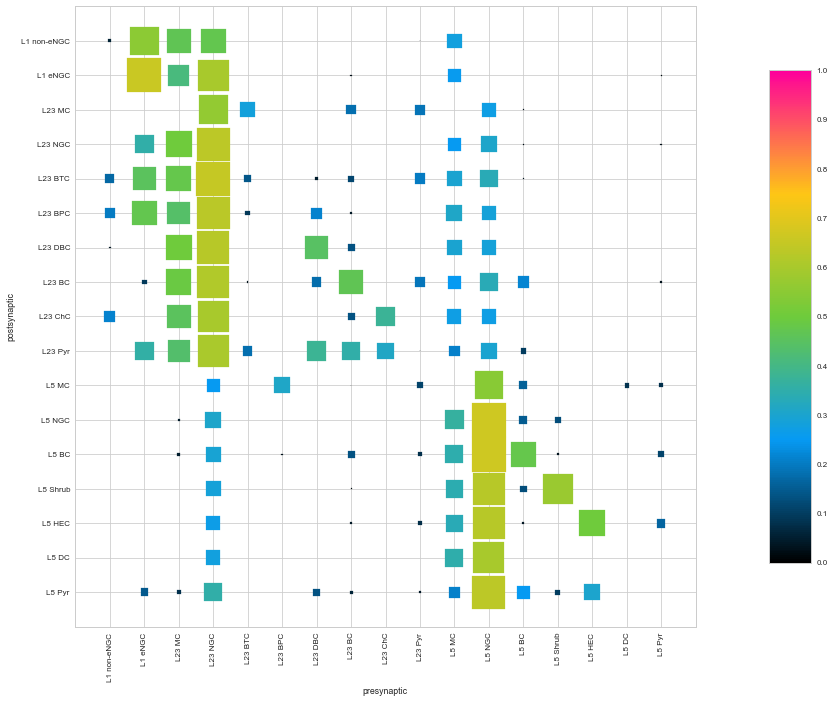

In [82]:
fig, axs = plot_connections(K/N, labels)
fig.savefig('connectivity_matrix_data.pdf')
fig.set_size_inches((15,15))

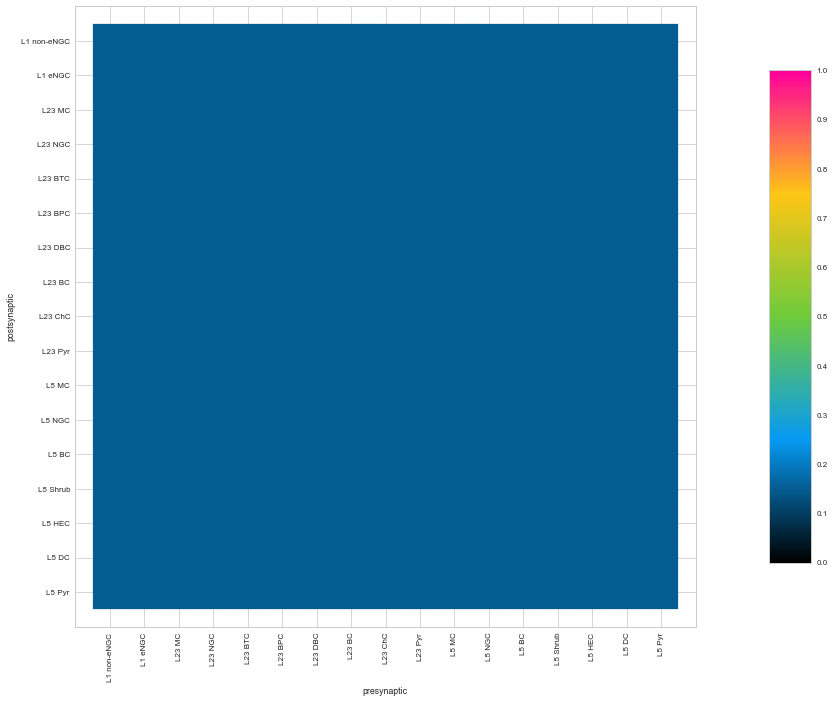

In [102]:
fig, axs = plot_connections(INI, labels)
fig.savefig('connectivity_matrix_INI.pdf')
fig.set_size_inches((15,15))

# Build connectivity matrix from rules

## $\beta$ Prior

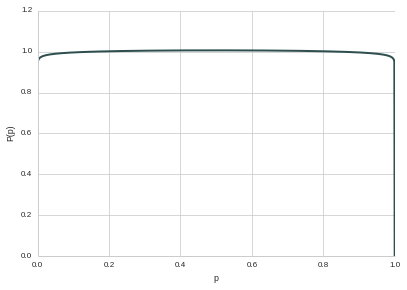

In [4]:
alpha = 1.01
beta = 1.01
# mean 1/100

fig, ax = plt.subplots()
sns.set_style('ticks')
p = np.linspace(0,1,1000)

ax.plot(p, stats.beta.pdf(p, alpha, beta),'-',color='darkslategray')
ax.set_xlabel('p')
ax.set_ylabel('P(p)')
sns.despine(fig)

# Dummy model: everything is connected to everything else with uniform probability

Full model cross-entropy 9.464 +- 0.2349


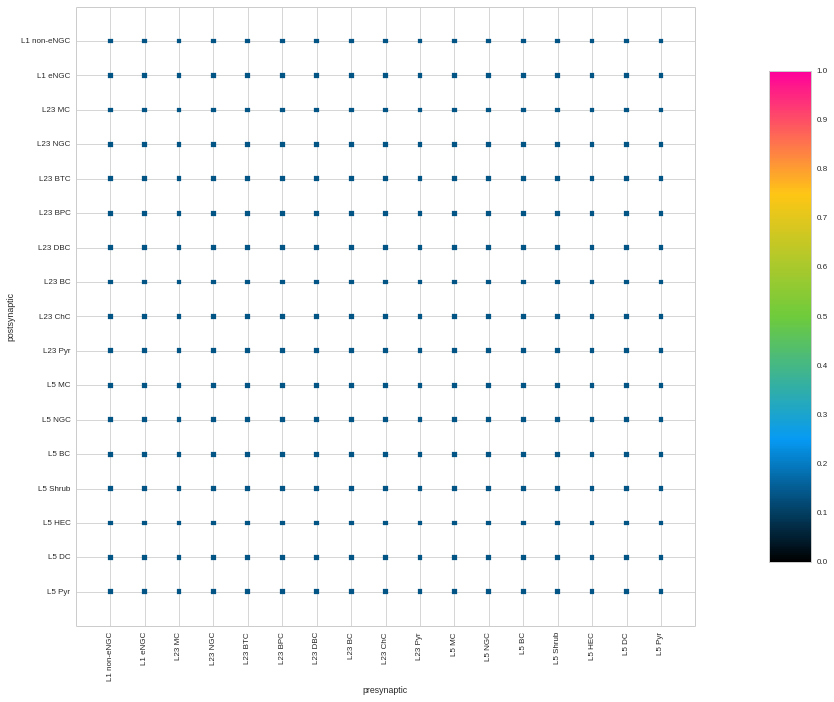

In [5]:
def uniform(coupled=None):
    if coupled is None:
        coupled = [np.ones_like(K, dtype=bool)]
    else:
        coupled.append(np.ones_like(K, dtype=bool))
    return coupled


m = MatrixModel(alpha, beta, uniform())

nll['uniform'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)#m.cross_entropy(K,N)
nparam['uniform'] = m.dof
m.fit(K,N)
models['uniform'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['uniform'].mean(), \
                                                 nll['uniform'].std(ddof = 1)))
sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels, vmax=1)
fig.set_size_inches((15,15))

# Dummy model 2: all connection probabilities are uniform within a layer and across layers

Full model cross-entropy 8.035 +- 0.1789


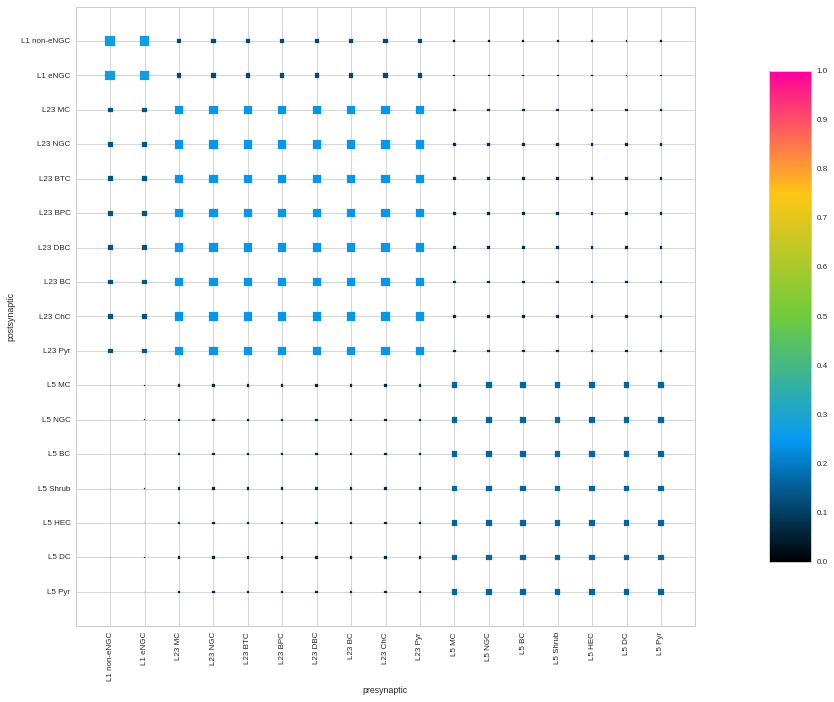

In [6]:
def uniform_layer(coupled=None):
    if coupled is None:
        coupled = []
    for layer in [layer1, layer23, layer5]: 
        for other_layer in [layer1, layer23, layer5]: 
            mr = np.zeros_like(K, dtype=bool)
            mr[layer, other_layer] = True
            coupled.append(mr)
    return coupled

m = MatrixModel(alpha, beta, uniform_layer())

nll['layer'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)
nparam['layer'] = m.dof
m.fit(K,N)
models['layer'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['layer'].mean(), \
                                                 nll['layer'].std(ddof = 1)))
sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels, vmax=1)
fig.set_size_inches((15,15))

# Dummy model 3: All connection probabilities are layer and cell type specific but otherwise uniform

Full model cross-entropy 7.22 +- 0.186


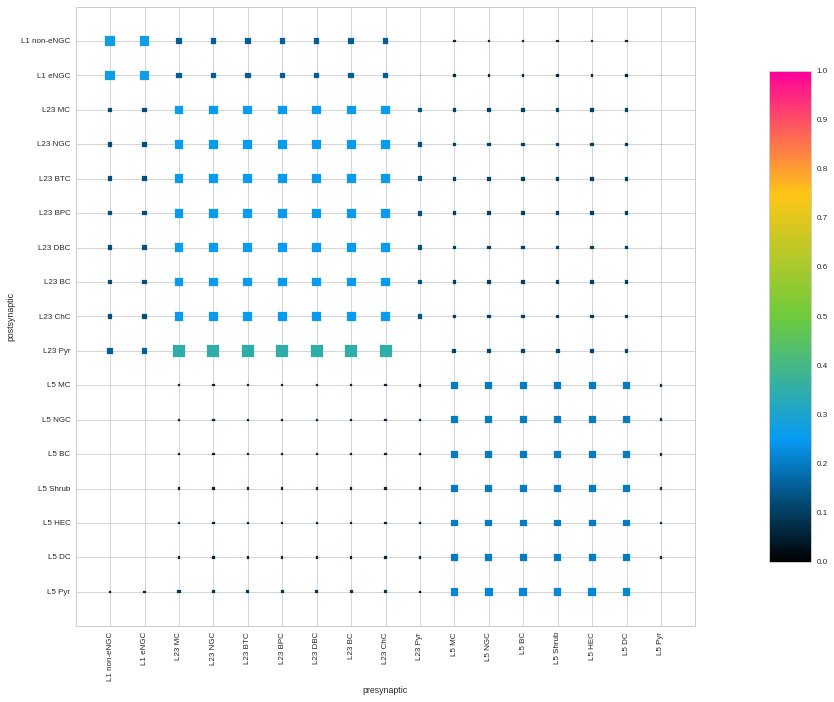

In [7]:
def uniform_layer_inhib_excit(coupled = None):
    if coupled is None:
        coupled = []
    for layer in [layer1, layer23i,layer23p, layer5i, layer5p]: 
        for other_layer in [layer1, layer23i,layer23p, layer5i, layer5p]: 
            mr = np.zeros_like(K, dtype=bool)
            mr[layer, other_layer] = True
            coupled.append(mr)
    return coupled

m = MatrixModel(alpha, beta, uniform_layer_inhib_excit())

nll[r'layer $\times$ inhib./excit.'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)
nparam[r'layer $\times$ inhib./excit.'] = m.dof
m.fit(K,N)
models[r'layer $\times$ inhib./excit.'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll[r'layer $\times$ inhib./excit.'].mean(), \
                                                 nll[r'layer $\times$ inhib./excit.'].std(ddof = 1)))
sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels, vmax=1)
fig.set_size_inches((15,15))

# Master Regulators

The master regulator rule is:

- NGCs connect to everyone in home layer and neighboring layer

- MCs connect to everyone except themselves in home layer and neighboring layer

Full model cross-entropy 4.241 +- 0.1464


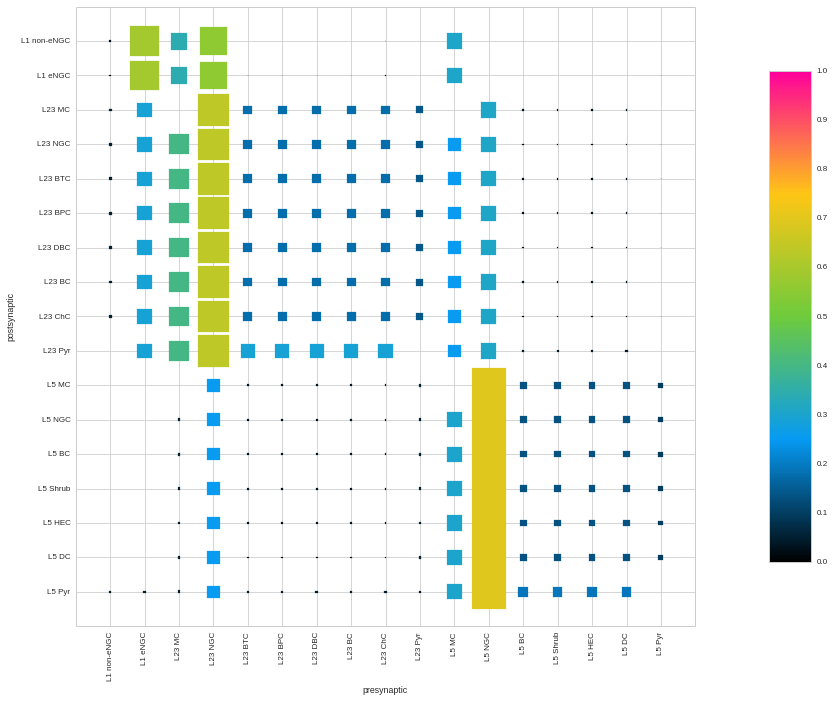

In [8]:
def master_reglators(coupled = None, accounted_for=None):
    """Rule 1: NGC connect to everyone in the layer and the neighboring layer. 
        In each layer the connectivity is independent of cell type.
        
        Rule 2: MC connect to everyone, except MC cells. 
    """
        

    if coupled is None:
        coupled = []
        
    if accounted_for is None:
        accounted_for = np.zeros_like(K, dtype=bool)
        

    cell = labels.index('L1 eNGC')
    for layer in [layer1, layer23]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)

    cell = labels.index('L23 NGC')
    for layer in [layer1, layer23, layer5]: # L23 NGC
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)

    cell = labels.index('L5 NGC')
    for layer in [layer23, layer5]: # L5 NGC
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)
    
    cell = labels.index('L23 MC')
    for layer in [layer1, layer23woMC, layer5woMC]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)

    cell = labels.index('L5 MC')
    for layer in [layer1, layer23woMC, layer5woMC]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)

    for c1, c2 in itertools.product([layer23mc, layer5mc],[layer23mc, layer5mc]):
        accounted_for[c1,c2] = True

    return coupled, accounted_for


coupled, accounted_for = master_reglators()
coupled = add_non_accounted(coupled, accounted_for)
m = MatrixModel(alpha, beta, coupled)
m.fit(K,N)


nll['master regulators'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)
nparam['master regulators'] = m.dof
models['master regulators'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['master regulators'].mean(), \
                                                 nll['master regulators'].std(ddof = 1)))

sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels)
fig.set_size_inches((15,15))

# ISI

Rule ISI:

- do not connect to pyramidal cells

- do only connect within home and downward neighboring layer


Full model cross-entropy 3.671 +- 0.142


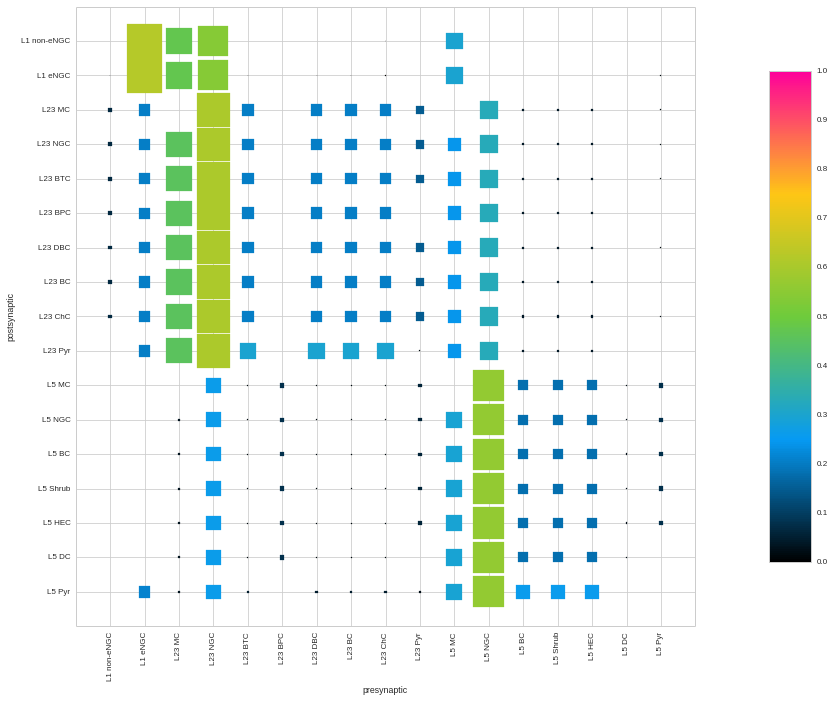

In [9]:
def ISI(coupled = None, accounted_for=None):

    if coupled is None:
        coupled = []
        
    if accounted_for is None:
        accounted_for = np.zeros_like(K, dtype=bool)
    
    # Rule ISI    
    cell = labels.index('L1 non-eNGC')
    for layer in [layer1, layer23i]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)
    mr = np.zeros_like(K, dtype=bool)
    mr[cell, layer23p] = True
    mr[cell, layer5p] = True
    coupled.append(mr)

    accounted_for[layer5, cell] = True # do not connect to layer 5


    cell = labels.index('L23 BPC')
    for layer in [layer23i, layer5i]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)
    mr = np.zeros_like(K, dtype=bool)
    mr[cell, layer23p] = True
    mr[cell, layer5p] = True
    coupled.append(mr)

    accounted_for[layer1, cell] = True # do not connect upwards
    accounted_for[layer23p, cell] = True # do not connect to pyramidal cells
    accounted_for[layer5p, cell] = True # do  not connect to pyramidal cells

    cell = labels.index('L5 DC')
    for layer in [layer5i]: 
        mr = np.zeros_like(K, dtype=bool)
        mr[layer,cell] = True
        coupled.append(mr)
    mr = np.zeros_like(K, dtype=bool)
    mr[cell, layer23p] = True
    mr[cell, layer5p] = True
    coupled.append(mr)

    accounted_for[layer5p, cell] = True # do  not connect to pyramidal cells
    accounted_for[layer1, cell] = True # do not connect upwards
    accounted_for[layer23, cell] = True # do not connect upwards


    return coupled, accounted_for

coupled, accounted_for = master_reglators()
coupled, accounted_for = ISI(coupled, accounted_for)
coupled = add_non_accounted(coupled, accounted_for)


m = MatrixModel(alpha, beta, coupled)
m.fit(K,N)


nll['ISI'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)
nparam['ISI'] = m.dof
models['ISI'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['ISI'].mean(), \
                                                 nll['ISI'].std(ddof = 1)))

sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels)
fig.set_size_inches((15,15))

# PSI

PSI rules:
* do connect to pyramidal cells
* do connect to self


Full model cross-entropy 2.821 +- 0.1274


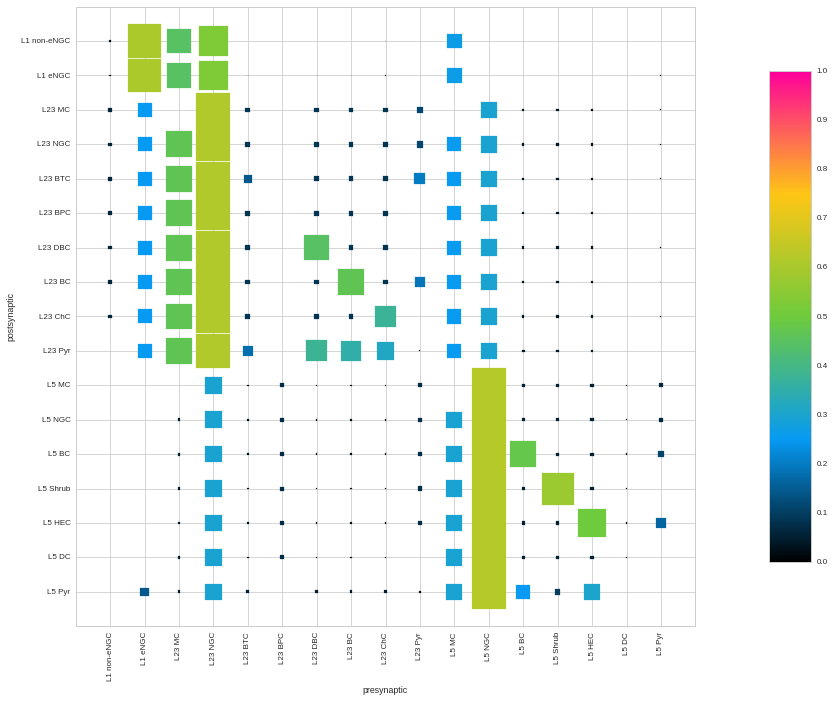

In [10]:
def PSI(coupled = None, accounted_for=None):

    if coupled is None:
        coupled = []
        
    if accounted_for is None:
        accounted_for = np.zeros_like(K, dtype=bool)

    # PSI

    for psi in ['L23 BTC','L23 DBC','L23 BC','L23 ChC', 'L5 BC', 'L5 Shrub', 'L5 HEC']:
        cell = labels.index(psi)
        mr = np.zeros_like(K, dtype=bool)
        mr[cell,cell] = True
        coupled.append(mr)

        mr = np.zeros_like(K, dtype=bool)
        mr[layer23p if 'L23' in psi else layer5p, cell] = True
        coupled.append(mr)

        mr = np.zeros_like(K, dtype=bool)
        mr[cell, layer23p if 'L23' in psi else layer5p] = True
        coupled.append(mr)
    return coupled, accounted_for
    
coupled, accounted_for = master_reglators()
coupled, accounted_for = ISI(coupled, accounted_for)
coupled, accounted_for = PSI(coupled, accounted_for)
coupled = add_non_accounted(coupled, accounted_for)


m = MatrixModel(alpha, beta, coupled)
m.fit(K,N)


nll['PSI'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)
nparam['PSI'] = m.dof
models['PSI'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['PSI'].mean(), \
                                                 nll['PSI'].std(ddof = 1)))
m.fit(K,N)
sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels)
fig.set_size_inches((15,15))

# Fit full model

Full model cross-entropy 1.972 +- 0.1479


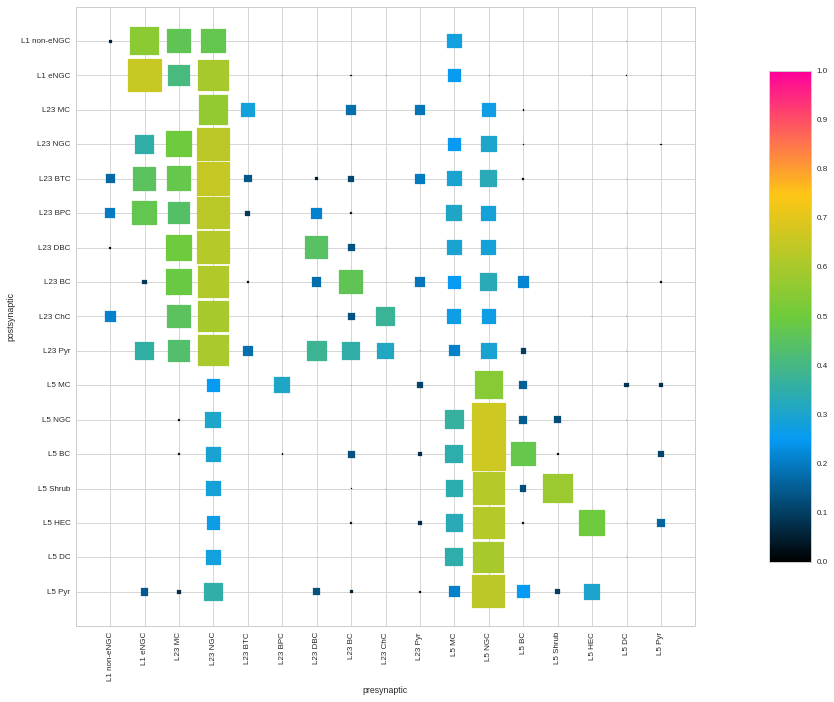

In [11]:
m = MatrixModel(alpha, beta)

nll['full model'] = m.bootstrap_cross_entropy(K, N, labels, cv=cv)#m.cross_entropy(K,N)
nparam['full model'] = m.dof
m.fit(K,N)
models['full model'] = m
print("Full model cross-entropy %.4g +- %.4g" % (nll['full model'].mean(), \
                                                 nll['full model'].std(ddof = 1)))
m.fit(K,N)

sns.set_context('notebook',font_scale=1.3)
fig, axs = plot_connections(m.P, labels)
fig.set_size_inches((15,15))

# Plot log likelihoods

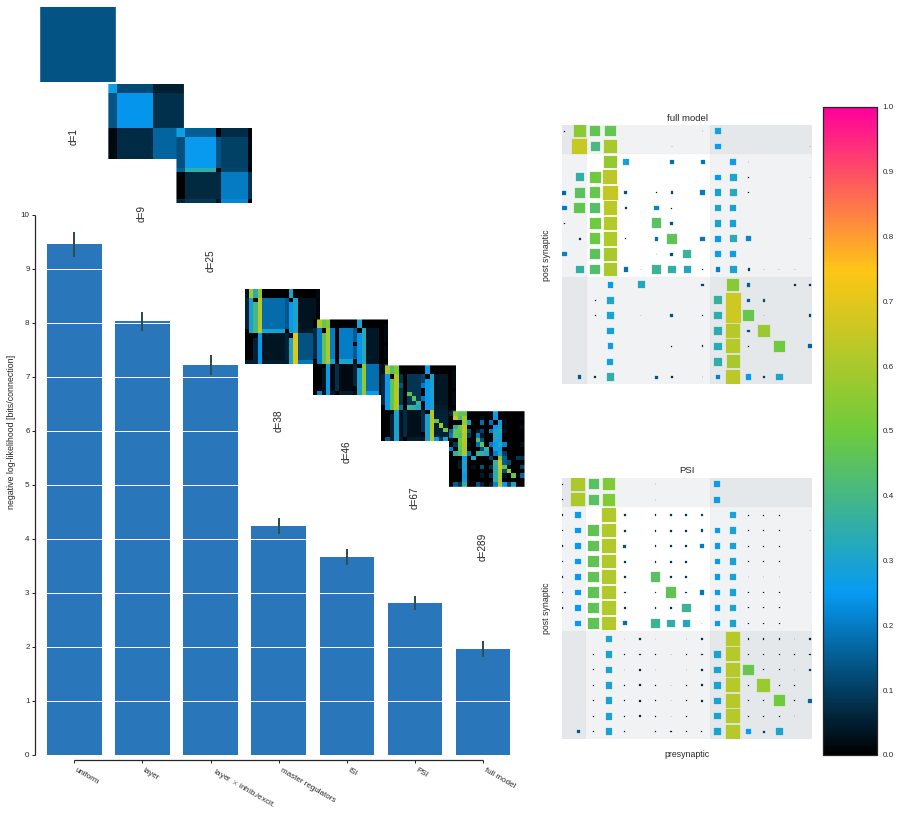

In [12]:
sns.set_style('ticks')


fig = plt.figure(figsize=(7,3.5), dpi=300)
gs = plt.GridSpec(2,13)

ax = fig.add_subplot(gs[:,:8])
labs, values = zip(*nll.items())
mu = np.fromiter(map(np.mean, values), dtype = float)
std = np.fromiter(map(lambda a: np.std(a, ddof=1), values), dtype = float)
ax.bar(np.arange(len(labs)), mu, align='center', color=sns.xkcd_rgb['bluish'] ,lw=0, zorder=-5)
ax.errorbar(np.arange(len(labs)), mu, std, fmt='.', ms=0, color='darkslategray' ,lw=2,capsize=0)
ax.set_ylim((0,12))
ax.set_xlim(-.5,len(labs))
fig.subplots_adjust(bottom=.3)

def transform(coord):
    return fig.transFigure.inverted().transform(
        ax.transData.transform(coord))

for i, (v, l, m) in enumerate(zip(mu, labs, models.values())):
    lims = np.hstack((transform((i-.5, v+3)), [.07,.07]))
    ax_tmp = fig.add_axes(lims)
    ax.text(i, v+2, 'd=%i' % nparam[l], rotation=90, ha='center')
#     extended_hinton(ax_tmp, m.P, m.P, cmin=0, cmax=1, vmax = .7, cmap=cmap, enforce_box=True)
    ax_tmp.imshow(m.P, cmap=cmap, interpolation='none', vmin=0, vmax=1, alpha=1)
    ax_tmp.axis('off')

ax.set_xticks(np.arange(len(labs)))
ax.set_ylabel('negative log-likelihood [bits/connection]')
ax.set_yticks(range(11))
ax.tick_params('x', length=3, width=1, which='major', pad = 3)
ax.tick_params('y', length=3, width=1, which='major', pad = 3)
sns.despine(fig, trim=True, offset = 5)
ax.yaxis.grid(True, which="both", linestyle='-', lw=1, color='w')
ax.xaxis.grid(False, which="both")
ax.set_xticklabels(labs, rotation=-30, ha='left')

sns.set_style('white')
lay = np.array(layers)
lay[lay == 3] = 2
lay[lay == 5] = 4
layer_boundaries = np.hstack((0, np.where(np.diff(lay) > 0)[0]+1, 17.5))-.5

ax = fig.add_subplot(gs[0,8:-1])
extended_hinton(ax, models['full model'].P, models['full model'].P, cmin=0, cmax=1, vmax = .7, \
                cmap=cmap, enforce_box=True, matrix_style=True)
ax.set_xticks(range(17))
ax.set_yticks(range(17))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_ylabel('post synaptic')
ax.set_title('full model')
for lb_low, lb_high in list(zip(layer_boundaries[0:-1],layer_boundaries[1:]))[::2]:
    ax.fill_between([lb_low, lb_high], 2*[-1], 2*[len(labels)],color='lightslategray', alpha=.1, zorder=-1)
    ax.fill_between([-1, len(labels)], 2*[lb_low], 2*[lb_high],color='lightslategray', alpha=.1, zorder=-1)

sns.despine(ax=ax, left=True, bottom=True)

ax = fig.add_subplot(gs[1,8:-1])
cnorm = extended_hinton(ax, models['PSI'].P, models['PSI'].P, cmin=0, cmax=1, vmax = .7, \
                cmap=cmap, enforce_box=True, matrix_style=True)
ax.set_xticks(range(17))
ax.set_yticks(range(17))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel('presynaptic')
ax.set_ylabel('post synaptic')
ax.set_title('PSI')
for lb_low, lb_high in list(zip(layer_boundaries[0:-1],layer_boundaries[1:]))[::2]:
    ax.fill_between([lb_low, lb_high], 2*[-1], 2*[len(labels)],color='lightslategray', alpha=.1, zorder=-1)
    ax.fill_between([-1, len(labels)], 2*[lb_low], 2*[lb_high],color='lightslategray', alpha=.1, zorder=-1)
sns.despine(ax=ax, left=True, bottom=True)

ax_color = fig.add_subplot(gs[:,-1])
cbar = ColorbarBase(ax_color, cmap=cmap, norm=cnorm)

for format in ['pdf','eps','svg']:
    fig.savefig('likelihoods.%s' % (format, ))
fig.set_size_inches((15,15))